<a href="https://colab.research.google.com/github/Zhang-Cheng-76200/CapsNet-LSTM/blob/main/CapsNet_LSTM_NO2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Conformal Prediction for Financial Time Series Using A Deep Ensemble with Hybrid CapsNet-LSTM Neural Networks: Using real world data (NO2)


In [1]:
import keras.backend as K
import tensorflow as tf

import keras
from keras import backend as K
from keras import initializers, layers, models, optimizers, callbacks, utils
from keras.models import load_model
from keras.models import model_from_json

from keras.initializers import glorot_uniform

from keras.initializers import *
from keras.layers import *
from keras.models import *
from keras.optimizers import *
from keras.callbacks import EarlyStopping
from keras.utils import *

from keras import losses
from keras.utils.io_utils import ask_to_proceed_with_overwrite
from tensorflow.python.platform import tf_logging as logging

import os
import copy
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass


In [2]:
import random

In [3]:
# # Set seed
# from numpy.random import seed
# seed(1)
# tf.random.set_seed(1)

In [4]:
# If code is running on TPU
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]


In [5]:
strategy = tf.distribute.TPUStrategy(resolver)

In [6]:
print(tf.__version__)

2.11.0


## Parsing the raw data

A couple of things to note:

- There is no need to save the data points as numpy arrays, regular lists is fine.
- The `time` list should contain every timestep (starting at zero), which is just a sequence of ordered numbers with the same length as the `series` list.
- The values of the `series` should be of `float` type. You can use Python's built-in `float` function to ensure this.

Begin by looking at the structure of the xlsx file that contains the data:

In [7]:
from google.colab import drive
drive.mount ('gdrive')

Mounted at gdrive


In [8]:
NO2_raw = pd.read_excel('/content/gdrive/MyDrive/NO2/NO2.xlsx')
NO2_raw

,Date,Time,NO2(GT)
0,2005-01-01,01:00:00,106.3
1,2005-01-01,02:00:00,128.6
2,2005-01-01,04:00:00,126.0
3,2005-01-01,05:00:00,105.7
4,2005-01-01,06:00:00,99.0
...,...,...,...
2167,2005-04-04,10:00:00,189.8
2168,2005-04-04,11:00:00,179.2
2169,2005-04-04,12:00:00,174.7
2170,2005-04-04,13:00:00,155.7


In [14]:
series = NO2_raw.iloc[:,2] # close price

In [15]:
time = []
for i in range(0, len(series)):
  time.append(i)

A helper function to plot the time series:

In [16]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

The next cell will use functions to compute the `time` and `series` and will save these as numpy arrays within the `G` dataclass. This cell will also plot the time series:

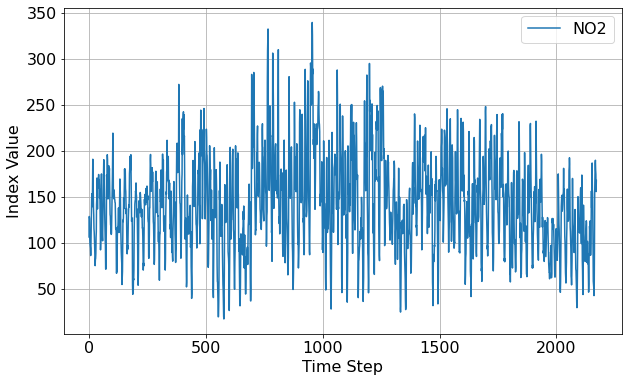

In [17]:
# Save all "global" variables within the G class (G stands for global)
@dataclass
class G:
    TIME = np.array(time)
    SERIES = np.array(series)
    SPLIT_TIME = int(len(series)*0.25)          # data splitting, the last G.SPLIT_TIME samples are test set.
    WINDOW_SIZE = 50                                # sequence length
    BATCH_SIZE = 32                                  # batch size

plt.rcParams['font.size'] = '16'
plt.figure(figsize=(10, 6))
plot_series(G.TIME, G.SERIES)
plt.ylabel("Index Value")
plt.xlabel("Time Step")
legend_drawn_flag = True
plt.legend(["NO2"], loc=0, frameon=legend_drawn_flag)
plt.savefig("/content/gdrive/MyDrive/NO2/figures/NO2_original.svg")
plt.show()

## Processing the data

The `train_test_split` and `windowed_dataset` functions:

In [18]:
def train_test_split(time, series, time_step=G.SPLIT_TIME):

    time_train = time[:-G.SPLIT_TIME]
    series_train = series[:-G.SPLIT_TIME]
    time_test = time[-G.SPLIT_TIME:]
    series_test = series[-G.SPLIT_TIME:]

    return time_train, series_train, time_test, series_test

# Split the dataset
time_train, series_train, time_test, series_test = train_test_split(G.TIME, G.SERIES)

In [19]:
def min_max_normalization(series):
  series = (series - min(series_train))/(max(series_train) - min(series_train))
  return series

In [20]:
series_norm = min_max_normalization(G.SERIES)

In [21]:
series_train_norm = series_norm[:-G.SPLIT_TIME]

series_test_norm = series_norm[-G.SPLIT_TIME:]

In [22]:
# Create train_set, val_set, and train_val_set. train_set and val_set are used for hyper=parameters tuning, and train_val_set is used for training.
def windowed_dataset(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    #ds = ds.batch(batch_size).prefetch(1)
    return ds
#train_set = windowed_dataset(series_train_norm, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE)
#cal_set = windowed_dataset(series_norm[G.SPLIT_TIME-G.WINDOW_SIZE:-G.SPLIT_TIME], window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE)
train_set = windowed_dataset(series_norm[0:-G.SPLIT_TIME], window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [23]:
def bootstrap_dataset(train_set):
  
  biglist = list(train_set)
  bootstrap_list1 =[]
  bootstrap_list2 =[]
  features = []
  labels = []

  for i in range(len(biglist)):
    
    bootstrap_list1.append(random.choice(biglist))

  
    bootstrap_list2.append(list(bootstrap_list1[i]))

 
    features.append(bootstrap_list2[i][0])  

    labels.append(bootstrap_list2[i][1])

  features_tensor = tf.convert_to_tensor(features)
  labels_tensor = tf.convert_to_tensor(labels)

  features_constant = tf.constant(features_tensor)
  labels_constant = tf.constant(labels_tensor)

  bootstrap_dataset = tf.data.Dataset.from_tensor_slices((features_constant, labels_constant))
  bootstrap_dataset = bootstrap_dataset.batch(G.BATCH_SIZE).prefetch(1)

  return bootstrap_dataset

In [24]:
def compute_metrics(true_series, forecast):
    
    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()   
    rmse = tf.math.sqrt(mse).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()
    mape = tf.keras.metrics.mean_absolute_percentage_error(true_series, forecast).numpy()
    return rmse, mae, mape

In [25]:
# Define PICP (PI coverage probability)

def PICP(upper_bound, lower_bound, real_value):
  c = np.array(0)
  for i in range(len(real_value)):
    if ((real_value[i] <= upper_bound[i]) & (real_value[i] >= lower_bound[i])):
      c = c+1
  picp = c / len(real_value)
  return picp


In [26]:
# Define NMPIW (Normalized Mean PI width)

def NMPIW(upper_bound, lower_bound, real_value):
   return tf.reduce_mean(upper_bound - lower_bound) / (np.max(real_value)-np.min(real_value))

In [27]:
def model_forecast(model, series, window_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(32).prefetch(1)
  forecast = model.predict(ds)
  return forecast

In [28]:
def reverse_normalization(series):
  series = series * (max(series_train) - min(series_train)) + min(series_train)
  return series

In [31]:
# Prepare callback

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='mae', factor=0.95,patience=5)

In [32]:
input_shape = (G.WINDOW_SIZE, 1)

In [33]:
# Define the number of bootstraps
num_bootstraps = 2
# Define alpha
alpha = 0.05

In [34]:
K.clear_session()

In [35]:
series_y = np.array(series[G.WINDOW_SIZE:])

# save time series
np.savetxt("/content/gdrive/MyDrive/NO2/files/test_set_values_NO2.csv", 
           series_test.T, delimiter=",")

np.savetxt("/content/gdrive/MyDrive/NO2/files/whole_values_NO2.csv", 
           series_y.T, delimiter=",")

## Compiling the model


### Defining the model architecture (CapsNet-LSTM)


In [36]:
# Squash function

def squash(vectors, axis=-1):
    """
    The non-linear activation used in Capsule. It drives the length of a large vector to near 1 and small vector to 0
    :param vectors: some vectors to be squashed, N-dim tensor
    :param axis: the axis to squash
    :return: a Tensor with same shape as input vectors
    """
    s_squared_norm = K.sum(K.square(vectors), axis, keepdims=True) 
    scale = s_squared_norm / (1 + s_squared_norm) / K.sqrt(s_squared_norm + K.epsilon())
    return scale * vectors


In [37]:
# Dynamic routing (layer)
#    The capsule layer. It is similar to Dense layer. Dense layer has `in_num` inputs, each is a scalar, the output of the 
#    neuron from the former layer, and it has `out_num` output neurons. CapsuleLayer just expand the output of the neuron
#    from scalar to vector. So its input shape = [None, input_num_capsule, input_dim_capsule] and output shape = \
#    [None, num_capsule, dim_capsule]. For Dense Layer, input_dim_capsule = dim_capsule = 1.

#    :param dim_capsule: dimension of the output vectors of the capsules in this layer
#    :param routings: number of iterations for the routing algorithm 

#@tf.keras.utils.register_keras_serializable() should use this line next time when need to save the model with a custom layer.
class Routing(keras.layers.Layer):

    def __init__(self, dim_capsule = 32 , routings=3, kernel_initializer='glorot_uniform'):
        super(Routing, self).__init__()
        self.dim_capsule = dim_capsule
        self.routings = routings
        self.kernel_initializer = initializers.get(kernel_initializer)

    def build(self, input_shape):
        # build tansform matrix which can convert one primary cap to a vector with the same order as the digit cap.
        # assert len(input_shape) >= 3  # The input Tensor should have shape=[None, input_num_capsule, input_dim_capsule]
        self.input_num_capsule = input_shape[1]
        self.input_dim_capsule = input_shape[2]
        
        # Transform matrix
       
        self.W = self.add_weight(shape=[self.input_num_capsule,self.dim_capsule, self.input_dim_capsule],initializer=self.kernel_initializer,name='W')

    def call(self, inputs): #training=None
        # inputs.shape=[input_num_capsule, input_dim_capsule]
        # inputs_expand.shape=[input_num_capsule, input_dim_capsule, 1]
        inputs_expand = K.expand_dims(inputs, -1)    

        # Compute `inputs * W` by scanning inputs_tiled on dimension 0.
        # x.shape=[None, input_num_capsule, input_dim_capsule, 1]
        # W.shape=[input_num_capsule, dim_capsule, input_dim_capsule]
        # Regard the first dimension as `batch` dimension,
        # then matmul: [dim_capsule, input_dim_capsule] x [input_dim_capsule, 1] -> [dim_capsule].
        # inputs_hat.shape = [None, input_num_capsule, dim_capsule, 1]     
          
        inputs_hat = K.map_fn(lambda x: K.batch_dot(self.W, x, [2, 1]), elems=inputs_expand) 

        inputs_hat = K.squeeze(inputs_hat, axis = -1)
        # inputs_hat.shape = [None, input_num_capsule, dim_capsule]
       
        # Begin: Routing algorithm ---------------------------------------------------------------------#
        # The prior for coupling coefficient, initialized as zeros.
        # b.shape = [None, self.input_num_capsule].
        b = tf.zeros(shape=[K.shape(inputs_hat)[0], self.input_num_capsule])
        
        assert self.routings > 0
        for i in range(self.routings):
            # c.shape=[batch_size, input_num_capsule]
            c = tf.nn.softmax(b, axis=-1)

            # c.shape =  [batch_size, input_num_capsule]
            # inputs_hat.shape=[batch_size, input_num_capsule, dim_capsule]
            # The first dimensions as `batch` dimension,
            # then matmal: [input_num_capsule] x [input_num_capsule, dim_capsule] -> [dim_capsule].
            # outputs.shape=[None, dim_capsule]
            
            #outputs = squash(K.batch_dot(c, inputs_hat, [1, 1])) 
            outputs = K.batch_dot(c, inputs_hat, [1, 1])

            if i < self.routings - 1:
                # outputs.shape =  [None, dim_capsule]
                # inputs_hat.shape=[None, input_num_capsule, dim_capsule]
                # The first dimension as `batch` dimension,
                # then matmal: [dim_capsule] x [input_num_capsule, dim_capsule]^T -> [input_num_capsule].
                # b.shape=[batch_size, input_num_capsule]
                b += K.batch_dot(outputs, inputs_hat, [1, 2])
       
        # End: Routing algorithm -----------------------------------------------------------------------#

        return outputs

    def compute_output_shape(self, input_shape):
        return tuple([None, self.dim_capsule])

    def get_config(self):
        config = super().get_config()
        config.update({
            "dim_capsule": self.dim_capsule,
            "routings": self.routings,
            "kernel_initializer": self.kernel_initializer,
        })
        return config

### Determine the number of Epoch

In [38]:
# Build the model with the default setting. LSTM units = 200, Convolution filters = 256, kernel size = 2, stride = 1, learning rate = 0.0005
def CapsNet_LSTM():
   
    input = tf.keras.layers.Input(shape=input_shape)
      
    # First layer
    conv1d_1 = tf.keras.layers.Conv1D(filters=256, kernel_size=2, strides=1, padding='causal', activation='relu', name = 'conv1d_1')(input)
          
    # Primary caps
  
    unsquashed_caps = tf.keras.layers.Reshape((G.WINDOW_SIZE, 32, 8))(conv1d_1)
    squashed_caps = tf.keras.layers.Lambda(squash)(unsquashed_caps)

    # Digit caps
     
    digit_caps = tf.keras.layers.TimeDistributed(Routing(dim_capsule = 256, routings = 3))(squashed_caps)

    # LSTM layer
    lstm = tf.keras.layers.LSTM(200)(digit_caps)

    # Dense layer

    output = tf.keras.layers.Dense(1)(lstm)

    model = keras.Model(inputs=input, outputs=output, name="capsnet_lstm")

    learning_rate = 0.0005
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate = learning_rate),
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=["mae"])

    return model

epoch number for CapsNet-LSTM is 500.

In [39]:
capsnet_lstm_ensemble = []
for i in range(num_bootstraps):
    with strategy.scope():
      capsnet_lstm = CapsNet_LSTM()
    # Fit with the entire dataset.
    capsnet_lstm.fit(bootstrap_dataset(train_set), epochs=200,callbacks = [reduce_lr],verbose = 0)  
    capsnet_lstm_ensemble.append(capsnet_lstm)

Instructions for updating:
Use fn_output_signature instead
Exception ignored in: <function Executor.__del__ at 0x7f67f8490820>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.9/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence
Exception ignored in: <function Executor.__del__ at 0x7f67f8490820>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.9/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


In [40]:
print(capsnet_lstm.summary())

Model: "capsnet_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 50, 1)]           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 50, 256)           768       
                                                                 
 reshape_1 (Reshape)         (None, 50, 32, 8)         0         
                                                                 
 lambda_1 (Lambda)           (None, 50, 32, 8)         0         
                                                                 
 time_distributed_1 (TimeDis  (None, 50, 256)          65536     
 tributed)                                                       
                                                                 
 lstm_1 (LSTM)               (None, 200)               365600    
                                                      

## Evaluating the forecast

Now it is time to evaluate the performance of the forecast. For this we use the `compute_metrics` function:

At this point only the model that will perform the forecast is ready but we still need to compute the actual forecast.



### Faster model forecasts


- The dataset is windowed using `window_size` rather than `window_size + 1`
- No shuffle should be used
- No need to split the data into features and labels
- A model is used to predict batches of the dataset

Now compute the actual forecast:

In [41]:
# Evaluate each model and the ensemble on the test set
# remember the last predicted value is not in the test set. It should be removed when producing y_hat series.

capsnet_lstm_ensemble_pred = tf.reduce_mean([model_forecast(capsnet_lstm, series_norm, G.WINDOW_SIZE).squeeze() for capsnet_lstm in capsnet_lstm_ensemble], axis=0)

series_hat_capsnet_lstm = reverse_normalization(capsnet_lstm_ensemble_pred)

67/67 [==============================] - 6s 28ms/step


In [42]:
series_y_hat_capsnet_lstm = np.array(list(series_hat_capsnet_lstm[:-1]))

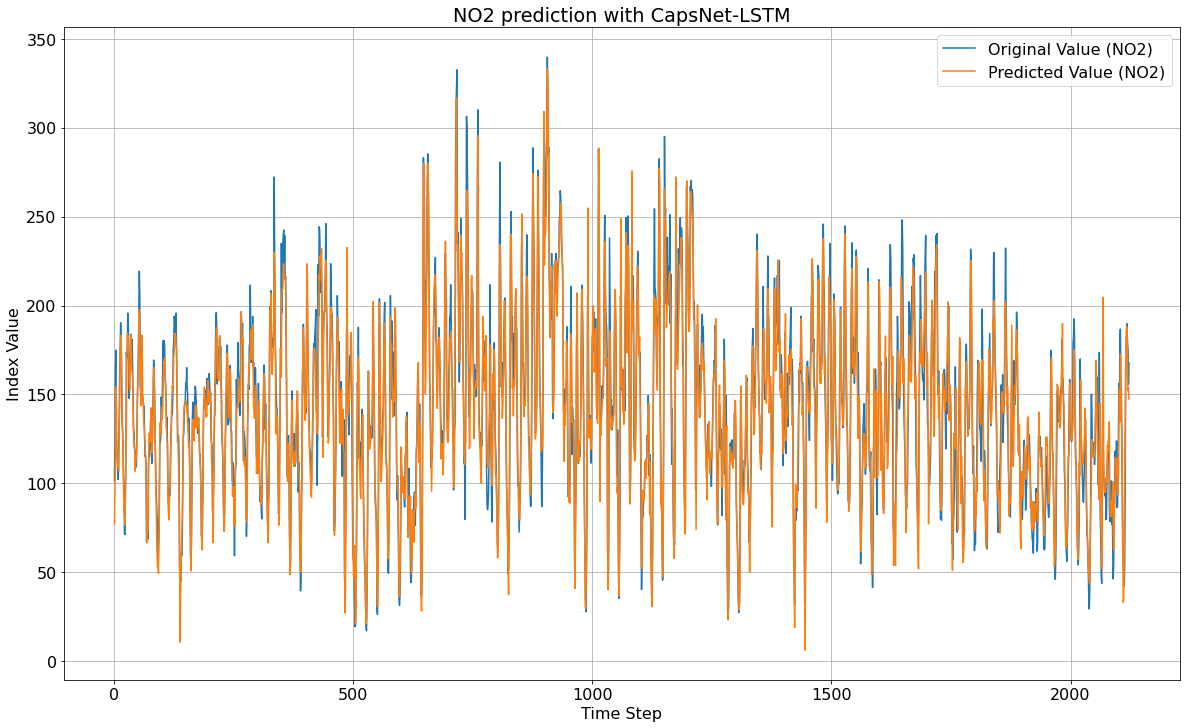

In [43]:
plt.figure(figsize=(20, 12))
plot_series(np.arange( 1, len(series)-G.WINDOW_SIZE+1 ), series_y)
plot_series(np.arange( 1, len(series)-G.WINDOW_SIZE+1 ), series_y_hat_capsnet_lstm)
plt.ylabel("Index Value")
plt.xlabel("Time Step")
plt.title("NO2 prediction with CapsNet-LSTM")
legend_drawn_flag = True
plt.legend(["Original Value (NO2)", "Predicted Value (NO2)"], loc=0, frameon=legend_drawn_flag)
plt.savefig("/content/gdrive/MyDrive/NO2/figures/capsnet_lstm_forecasts_whole_NO2.svg")

In [44]:
# error series

abs_error_capsnet_lstm = np.abs(series_y-series_y_hat_capsnet_lstm)
series_test_hat_capsnet_lstm = series_y_hat_capsnet_lstm[-G.SPLIT_TIME:]
series_test_hat_capsnet_lstm_up = []
series_test_hat_capsnet_lstm_low = []

In [45]:
for i in range(len(series_test)):
  error = np.sort(abs_error_capsnet_lstm[i:i-len(series_test)], kind='quicksort')[::-1]
  up_bound = np.quantile(error, [1-alpha])
  low_bound = -np.quantile(error, [1-alpha])
  series_test_hat_capsnet_lstm_up.append(series_test_hat_capsnet_lstm[i] + up_bound)
  series_test_hat_capsnet_lstm_low.append(series_test_hat_capsnet_lstm[i] + low_bound)

In [46]:
series_test_hat_capsnet_lstm_up = np.array(series_test_hat_capsnet_lstm_up)
series_test_hat_capsnet_lstm_low = np.array(series_test_hat_capsnet_lstm_low)

In [47]:
series_test_hat_capsnet_lstm_up = np.squeeze(series_test_hat_capsnet_lstm_up)
series_test_hat_capsnet_lstm_low = np.squeeze(series_test_hat_capsnet_lstm_low)

In [48]:
bound_width_capsnet_lstm = series_test_hat_capsnet_lstm_up-series_test_hat_capsnet_lstm_low

In [49]:
PICP_capsnet_lstm = PICP(series_test_hat_capsnet_lstm_up, series_test_hat_capsnet_lstm_low, series_test)

In [50]:
PICP_capsnet_lstm

0.9263351749539595

In [51]:
NMPIW_capsnet_lstm = NMPIW(series_test_hat_capsnet_lstm_up, series_test_hat_capsnet_lstm_low, series_test)

In [52]:
NMPIW_capsnet_lstm

<tf.Tensor: shape=(), dtype=float64, numpy=0.3344537369705751>

In [53]:
rmse_capsnet_lstm, mae_capsnet_lstm, mape_capsnet_lstm= compute_metrics(series_test, series_test_hat_capsnet_lstm)

print(f"rmse: {rmse_capsnet_lstm:.2f}, mae: {mae_capsnet_lstm:.2f} , mape: {mape_capsnet_lstm:.2f} for forecast")

rmse: 20.04, mae: 15.38 , mape: 13.52 for forecast


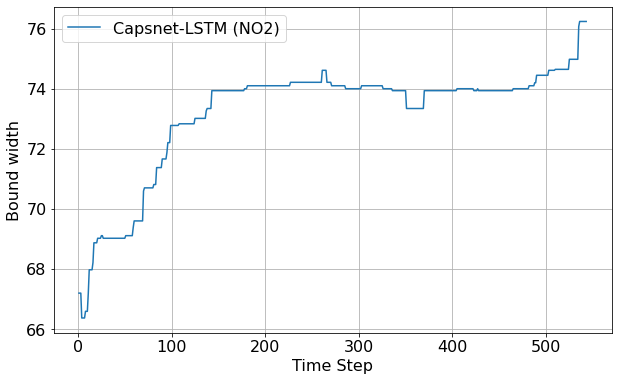

In [54]:
plt.figure(figsize=(10, 6))
plot_series(np.arange( 1, len(time_test)+1 ), bound_width_capsnet_lstm)
plt.ylabel("Bound width")
plt.xlabel("Time Step")
legend_drawn_flag = True
plt.legend(["Capsnet-LSTM (NO2)"], loc=0, frameon=legend_drawn_flag)
plt.savefig("/content/gdrive/MyDrive/NO2/figures/capsnet_lstm_forecasts_bound_width_NO2.svg")

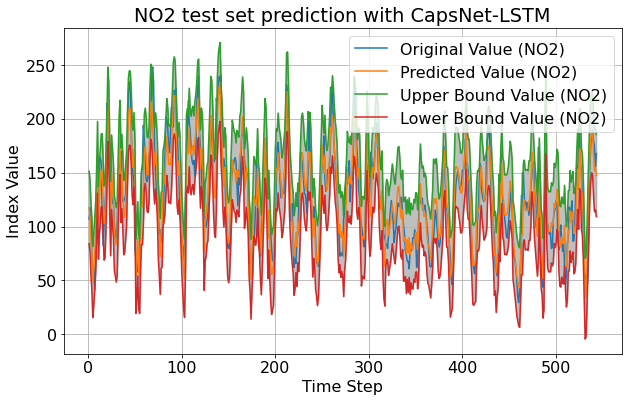

In [55]:
# Plot the forecast

plt.figure(figsize=(10, 6))
plot_series(np.arange( 1, len(time_test)+1 ), series_test)
plot_series(np.arange( 1, len(time_test)+1 ), series_test_hat_capsnet_lstm)
plot_series(np.arange( 1, len(time_test)+1 ), series_test_hat_capsnet_lstm_up)
plot_series(np.arange( 1, len(time_test)+1 ), series_test_hat_capsnet_lstm_low)
plt.fill_between(np.arange( 1, len(time_test)+1 ), series_test_hat_capsnet_lstm_up, series_test_hat_capsnet_lstm_low, color='gray', alpha=0.5)
plt.ylabel("Index Value")
plt.xlabel("Time Step")
plt.title("NO2 test set prediction with CapsNet-LSTM")
legend_drawn_flag = True
plt.legend(["Original Value (NO2)", "Predicted Value (NO2)", "Upper Bound Value (NO2)", "Lower Bound Value (NO2)"], loc=0, frameon=legend_drawn_flag)
plt.savefig("/content/gdrive/MyDrive/NO2/figures/capsnet_lstm_forecasts_bounds_NO2.svg")

In [56]:
# Save_weights model

capsnet_lstm_ensemble[0].save_weights("/content/gdrive/MyDrive/NO2/capsnet_lstm_ensemble/capsnet_lstm_NO2_0.h5", overwrite=True, save_format=None, options=None)
capsnet_lstm_ensemble[1].save_weights("/content/gdrive/MyDrive/NO2/capsnet_lstm_ensemble/capsnet_lstm_NO2_1.h5", overwrite=True, save_format=None, options=None)
capsnet_lstm_ensemble[2].save_weights("/content/gdrive/MyDrive/NO2/capsnet_lstm_ensemble/capsnet_lstm_NO2_2.h5", overwrite=True, save_format=None, options=None)
capsnet_lstm_ensemble[3].save_weights("/content/gdrive/MyDrive/NO2/capsnet_lstm_ensemble/capsnet_lstm_NO2_3.h5", overwrite=True, save_format=None, options=None)
capsnet_lstm_ensemble[4].save_weights("/content/gdrive/MyDrive/NO2/capsnet_lstm_ensemble/capsnet_lstm_NO2_4.h5", overwrite=True, save_format=None, options=None)
capsnet_lstm_ensemble[5].save_weights("/content/gdrive/MyDrive/NO2/capsnet_lstm_ensemble/capsnet_lstm_NO2_5.h5", overwrite=True, save_format=None, options=None)
capsnet_lstm_ensemble[6].save_weights("/content/gdrive/MyDrive/NO2/capsnet_lstm_ensemble/capsnet_lstm_NO2_6.h5", overwrite=True, save_format=None, options=None)
capsnet_lstm_ensemble[7].save_weights("/content/gdrive/MyDrive/NO2/capsnet_lstm_ensemble/capsnet_lstm_NO2_7.h5", overwrite=True, save_format=None, options=None)
capsnet_lstm_ensemble[8].save_weights("/content/gdrive/MyDrive/NO2/capsnet_lstm_ensemble/capsnet_lstm_NO2_8.h5", overwrite=True, save_format=None, options=None)
capsnet_lstm_ensemble[9].save_weights("/content/gdrive/MyDrive/NO2/capsnet_lstm_ensemble/capsnet_lstm_NO2_9.h5", overwrite=True, save_format=None, options=None)
capsnet_lstm_ensemble[10].save_weights("/content/gdrive/MyDrive/NO2/capsnet_lstm_ensemble/capsnet_lstm_NO2_10.h5", overwrite=True, save_format=None, options=None)
capsnet_lstm_ensemble[11].save_weights("/content/gdrive/MyDrive/NO2/capsnet_lstm_ensemble/capsnet_lstm_NO2_11.h5", overwrite=True, save_format=None, options=None)
capsnet_lstm_ensemble[12].save_weights("/content/gdrive/MyDrive/NO2/capsnet_lstm_ensemble/capsnet_lstm_NO2_12.h5", overwrite=True, save_format=None, options=None)
capsnet_lstm_ensemble[13].save_weights("/content/gdrive/MyDrive/NO2/capsnet_lstm_ensemble/capsnet_lstm_NO2_13.h5", overwrite=True, save_format=None, options=None)
capsnet_lstm_ensemble[14].save_weights("/content/gdrive/MyDrive/NO2/capsnet_lstm_ensemble/capsnet_lstm_NO2_14.h5", overwrite=True, save_format=None, options=None)
capsnet_lstm_ensemble[15].save_weights("/content/gdrive/MyDrive/NO2/capsnet_lstm_ensemble/capsnet_lstm_NO2_15.h5", overwrite=True, save_format=None, options=None)
capsnet_lstm_ensemble[16].save_weights("/content/gdrive/MyDrive/NO2/capsnet_lstm_ensemble/capsnet_lstm_NO2_16.h5", overwrite=True, save_format=None, options=None)
capsnet_lstm_ensemble[17].save_weights("/content/gdrive/MyDrive/NO2/capsnet_lstm_ensemble/capsnet_lstm_NO2_17.h5", overwrite=True, save_format=None, options=None)
capsnet_lstm_ensemble[18].save_weights("/content/gdrive/MyDrive/NO2/capsnet_lstm_ensemble/capsnet_lstm_NO2_18.h5", overwrite=True, save_format=None, options=None)
capsnet_lstm_ensemble[19].save_weights("/content/gdrive/MyDrive/NO2/capsnet_lstm_ensemble/capsnet_lstm_NO2_19.h5", overwrite=True, save_format=None, options=None)

IndexError: ignored

In [ ]:

capsnet_lstm.save_weights('/content/gdrive/MyDrive/NO2/capsnet_lstm_NO2_weights.h5', overwrite=True, save_format=None, options=None)

In [ ]:
# Save predicted values

np.savetxt("/content/gdrive/MyDrive/NO2/capsnet_lstm_predicted_mean_NO2.csv", 
           series_test_hat_capsnet_lstm.T, delimiter=",")

np.savetxt("/content/gdrive/MyDrive/NO2/capsnet_lstm_predicted_up_NO2.csv", 
           series_test_hat_capsnet_lstm_up.T, delimiter=",")

np.savetxt("/content/gdrive/MyDrive/NO2/capsnet_lstm_predicted_low_NO2.csv", 
           series_test_hat_capsnet_lstm_low.T, delimiter=",")

np.savetxt("/content/gdrive/MyDrive/NO2/capsnet_lstm_predicted_whole_NO2.csv", 
           series_y_hat_capsnet_lstm.T, delimiter=",")

## Baseline (LSTM, CNN-LSTM)

### LSTM

In [57]:
# Build the model with the best hp.
def LSTM():
   
    model = tf.keras.models.Sequential([
          tf.keras.layers.LSTM(200, input_shape=[G.WINDOW_SIZE, 1]),
          tf.keras.layers.Dense(1)
    ])
    learning_rate = 0.0005
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=["mae"])

    return model

In [58]:
lstm_ensemble = []
for i in range(num_bootstraps):
    with strategy.scope():
      lstm = LSTM()
    # Fit with the entire dataset.
    lstm.fit(bootstrap_dataset(train_set), epochs=200,callbacks = [reduce_lr],verbose = 0)  
    lstm_ensemble.append(lstm)

Exception ignored in: <function Executor.__del__ at 0x7f67f8490820>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.9/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence
Exception ignored in: <function Executor.__del__ at 0x7f67f8490820>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.9/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


In [59]:
print(lstm.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 200)               161600    
                                                                 
 dense_3 (Dense)             (None, 1)                 201       
                                                                 
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
None


In [60]:
# Evaluate each model and the ensemble on the test set
# remember the last predicted value is not in the test set. It should be removed when producing y_hat series.

lstm_ensemble_pred = tf.reduce_mean([model_forecast(lstm, series_norm, G.WINDOW_SIZE).squeeze() for lstm in lstm_ensemble], axis=0)

series_hat_lstm = reverse_normalization(lstm_ensemble_pred)

67/67 [==============================] - 4s 20ms/step


In [61]:

series_y_hat_lstm = np.array(list(series_hat_lstm[:-1]))

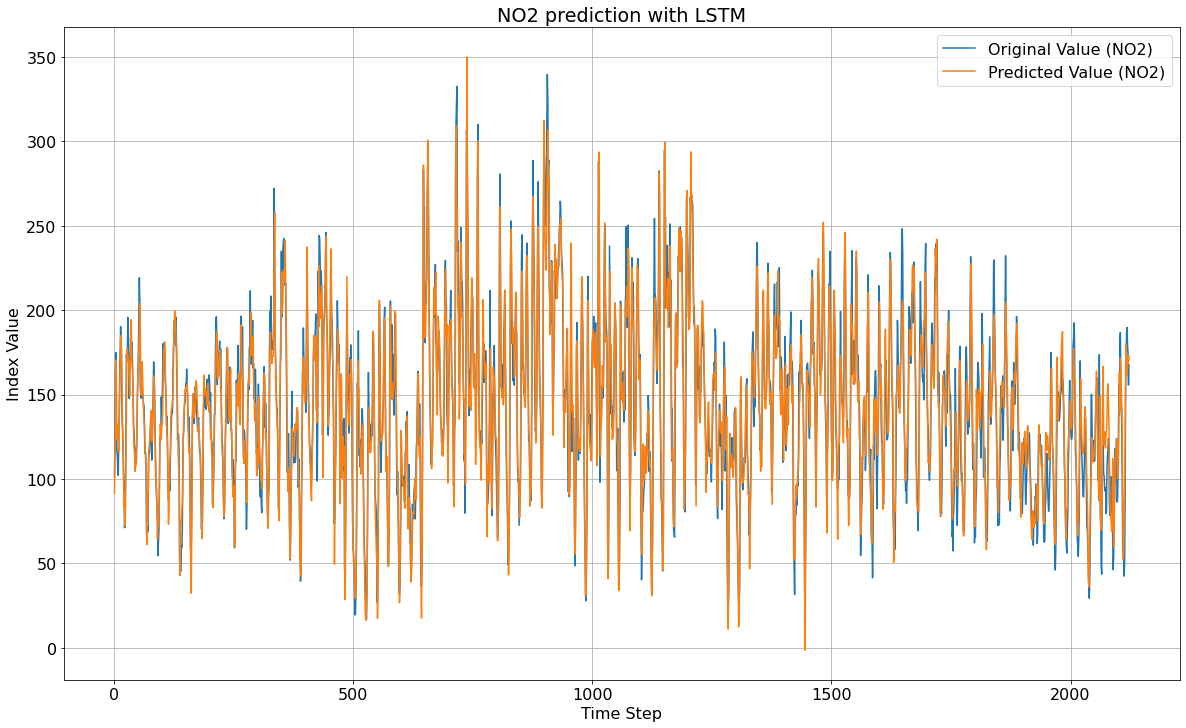

In [62]:
plt.figure(figsize=(20, 12))
plot_series(np.arange( 1, len(series)-G.WINDOW_SIZE+1 ), series_y)
plot_series(np.arange( 1, len(series)-G.WINDOW_SIZE+1 ), series_y_hat_lstm)
plt.ylabel("Index Value")
plt.xlabel("Time Step")
plt.title("NO2 prediction with LSTM")
legend_drawn_flag = True
plt.legend(["Original Value (NO2)", "Predicted Value (NO2)"], loc=0, frameon=legend_drawn_flag)
plt.savefig("/content/gdrive/MyDrive/NO2/figures/lstm_forecasts_whole_NO2.svg")

In [63]:
# error series

abs_error_lstm = np.abs(series_y-series_y_hat_lstm)
series_test_hat_lstm = series_y_hat_lstm[-G.SPLIT_TIME:]
series_test_hat_lstm_up = []
series_test_hat_lstm_low = []

In [64]:
for i in range(len(series_test)):
  error = np.sort(abs_error_lstm[i:i-len(series_test)], kind='quicksort')[::-1]
  up_bound = np.quantile(error, [1-alpha])
  low_bound = -np.quantile(error, [1-alpha])
  series_test_hat_lstm_up.append(series_test_hat_lstm[i] + up_bound)
  series_test_hat_lstm_low.append(series_test_hat_lstm[i] + low_bound)

In [65]:
series_test_hat_lstm_up = np.array(series_test_hat_lstm_up)
series_test_hat_lstm_low = np.array(series_test_hat_lstm_low)

In [66]:
series_test_hat_lstm_up = np.squeeze(series_test_hat_lstm_up)
series_test_hat_lstm_low = np.squeeze(series_test_hat_lstm_low)

In [67]:
bound_width_lstm = series_test_hat_lstm_up-series_test_hat_lstm_low

In [68]:
PICP_lstm = PICP(series_test_hat_lstm_up, series_test_hat_lstm_low, series_test)

In [69]:
PICP_lstm

0.9410681399631676

In [70]:
NMPIW_lstm = NMPIW(series_test_hat_lstm_up, series_test_hat_lstm_low, series_test)

In [71]:
NMPIW_lstm

<tf.Tensor: shape=(), dtype=float64, numpy=0.34080508087942246>

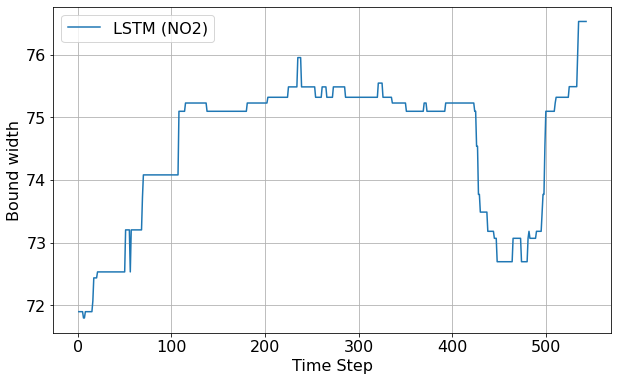

In [72]:
plt.figure(figsize=(10, 6))
plot_series(np.arange( 1, len(time_test)+1 ), bound_width_lstm)
plt.ylabel("Bound width")
plt.xlabel("Time Step")
legend_drawn_flag = True
plt.legend(["LSTM (NO2)"], loc=0, frameon=legend_drawn_flag)
plt.savefig("/content/gdrive/MyDrive/NO2/figures/lstm_forecasts_bound_width_NO2.svg")

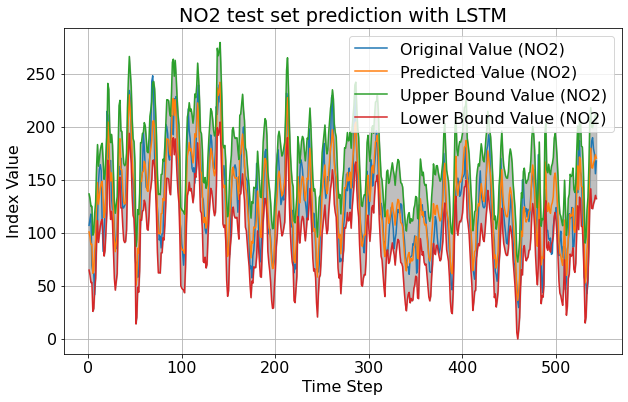

In [73]:
# Plot the forecast

plt.figure(figsize=(10, 6))
plot_series(np.arange( 1, len(time_test)+1 ), series_test)
plot_series(np.arange( 1, len(time_test)+1 ), series_test_hat_lstm)
plot_series(np.arange( 1, len(time_test)+1 ), series_test_hat_lstm_up)
plot_series(np.arange( 1, len(time_test)+1 ), series_test_hat_lstm_low)
plt.fill_between(np.arange( 1, len(time_test)+1 ), series_test_hat_lstm_up, series_test_hat_lstm_low, color='gray', alpha=0.5)
plt.ylabel("Index Value")
plt.xlabel("Time Step")
plt.title("NO2 test set prediction with LSTM")
legend_drawn_flag = True
plt.legend(["Original Value (NO2)", "Predicted Value (NO2)", "Upper Bound Value (NO2)", "Lower Bound Value (NO2)"], loc=0, frameon=legend_drawn_flag)
plt.savefig("/content/gdrive/MyDrive/NO2/figures/lstm_forecasts_bounds_NO2.svg")

In [74]:
rmse_lstm, mae_lstm, mape_lstm= compute_metrics(series_test, series_test_hat_lstm)

print(f"rmse: {rmse_lstm:.2f}, mae: {mae_lstm:.2f} , mape: {mape_lstm:.2f} for forecast")

rmse: 19.58, mae: 15.58 , mape: 14.42 for forecast


In [75]:
# Save model

lstm_ensemble[0].save("/content/gdrive/MyDrive/NO2/lstm_ensemble/lstm_NO2_0.h5")
lstm_ensemble[1].save("/content/gdrive/MyDrive/NO2/lstm_ensemble/lstm_NO2_1.h5")
lstm_ensemble[2].save("/content/gdrive/MyDrive/NO2/lstm_ensemble/lstm_NO2_2.h5")
lstm_ensemble[3].save("/content/gdrive/MyDrive/NO2/lstm_ensemble/lstm_NO2_3.h5")
lstm_ensemble[4].save("/content/gdrive/MyDrive/NO2/lstm_ensemble/lstm_NO2_4.h5")
lstm_ensemble[5].save("/content/gdrive/MyDrive/NO2/lstm_ensemble/lstm_NO2_5.h5")
lstm_ensemble[6].save("/content/gdrive/MyDrive/NO2/lstm_ensemble/lstm_NO2_6.h5")
lstm_ensemble[7].save("/content/gdrive/MyDrive/NO2/lstm_ensemble/lstm_NO2_7.h5")
lstm_ensemble[8].save("/content/gdrive/MyDrive/NO2/lstm_ensemble/lstm_NO2_8.h5")
lstm_ensemble[9].save("/content/gdrive/MyDrive/NO2/lstm_ensemble/lstm_NO2_9.h5")
lstm_ensemble[10].save("/content/gdrive/MyDrive/NO2/lstm_ensemble/lstm_NO2_10.h5")
lstm_ensemble[11].save("/content/gdrive/MyDrive/NO2/lstm_ensemble/lstm_NO2_11.h5")
lstm_ensemble[12].save("/content/gdrive/MyDrive/NO2/lstm_ensemble/lstm_NO2_12.h5")
lstm_ensemble[13].save("/content/gdrive/MyDrive/NO2/lstm_ensemble/lstm_NO2_13.h5")
lstm_ensemble[14].save("/content/gdrive/MyDrive/NO2/lstm_ensemble/lstm_NO2_14.h5")
lstm_ensemble[15].save("/content/gdrive/MyDrive/NO2/lstm_ensemble/lstm_NO2_15.h5")
lstm_ensemble[16].save("/content/gdrive/MyDrive/NO2/lstm_ensemble/lstm_NO2_16.h5")
lstm_ensemble[17].save("/content/gdrive/MyDrive/NO2/lstm_ensemble/lstm_NO2_17.h5")
lstm_ensemble[18].save("/content/gdrive/MyDrive/NO2/lstm_ensemble/lstm_NO2_18.h5")
lstm_ensemble[19].save("/content/gdrive/MyDrive/NO2/lstm_ensemble/lstm_NO2_19.h5")


IndexError: ignored

In [ ]:
# Save predicted values

np.savetxt("/content/gdrive/MyDrive/NO2/lstm_predicted_mean_NO2.csv", 
           series_test_hat_lstm.T, delimiter=",")

np.savetxt("/content/gdrive/MyDrive/NO2/lstm_predicted_up_NO2.csv", 
           series_test_hat_lstm_up.T, delimiter=",")

np.savetxt("/content/gdrive/MyDrive/NO2/lstm_predicted_low_NO2.csv", 
           series_test_hat_lstm_low.T, delimiter=",")

np.savetxt("/content/gdrive/MyDrive/NO2/lstm_predicted_whole_NO2.csv", 
           series_y_hat_lstm.T, delimiter=",")

### CNN-LSTM

In [76]:
def CNN_LSTM():
   
    model = tf.keras.models.Sequential([
          tf.keras.layers.Conv1D(filters=256, kernel_size=2,
                                 strides=1,
                                 activation="relu",
                                 padding='causal',
                                 input_shape=[G.WINDOW_SIZE, 1]),
          tf.keras.layers.MaxPooling1D(pool_size=2, strides=1, padding="same"),
          tf.keras.layers.LSTM(200),
          tf.keras.layers.Dense(1)
    ])
    learning_rate = 0.0005
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=["mae"])

    return model

Epoch number is 500.

In [77]:
cnn_lstm_ensemble = []
for i in range(num_bootstraps):
    with strategy.scope():
      cnn_lstm = CNN_LSTM()
    # Fit with the entire dataset.
    cnn_lstm.fit(bootstrap_dataset(train_set), epochs=200,callbacks = [reduce_lr],verbose = 0)  
    cnn_lstm_ensemble.append(cnn_lstm)

Exception ignored in: <function Executor.__del__ at 0x7f67f8490820>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.9/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence
Exception ignored in: <function Executor.__del__ at 0x7f67f8490820>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.9/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


In [78]:
print(cnn_lstm.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 50, 256)           768       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 50, 256)          0         
 1D)                                                             
                                                                 
 lstm_5 (LSTM)               (None, 200)               365600    
                                                                 
 dense_5 (Dense)             (None, 1)                 201       
                                                                 
Total params: 366,569
Trainable params: 366,569
Non-trainable params: 0
_________________________________________________________________
None


In [79]:
# Evaluate each model and the ensemble on the test set
# remember the last predicted value is not in the test set. It should be removed when producing y_hat series.

cnn_lstm_ensemble_pred = tf.reduce_mean([model_forecast(cnn_lstm, series_norm, G.WINDOW_SIZE).squeeze() for cnn_lstm in cnn_lstm_ensemble], axis=0)

series_hat_cnn_lstm = reverse_normalization(cnn_lstm_ensemble_pred)

67/67 [==============================] - 4s 20ms/step


In [80]:
series_y_hat_cnn_lstm = np.array(list(series_hat_cnn_lstm[:-1]))

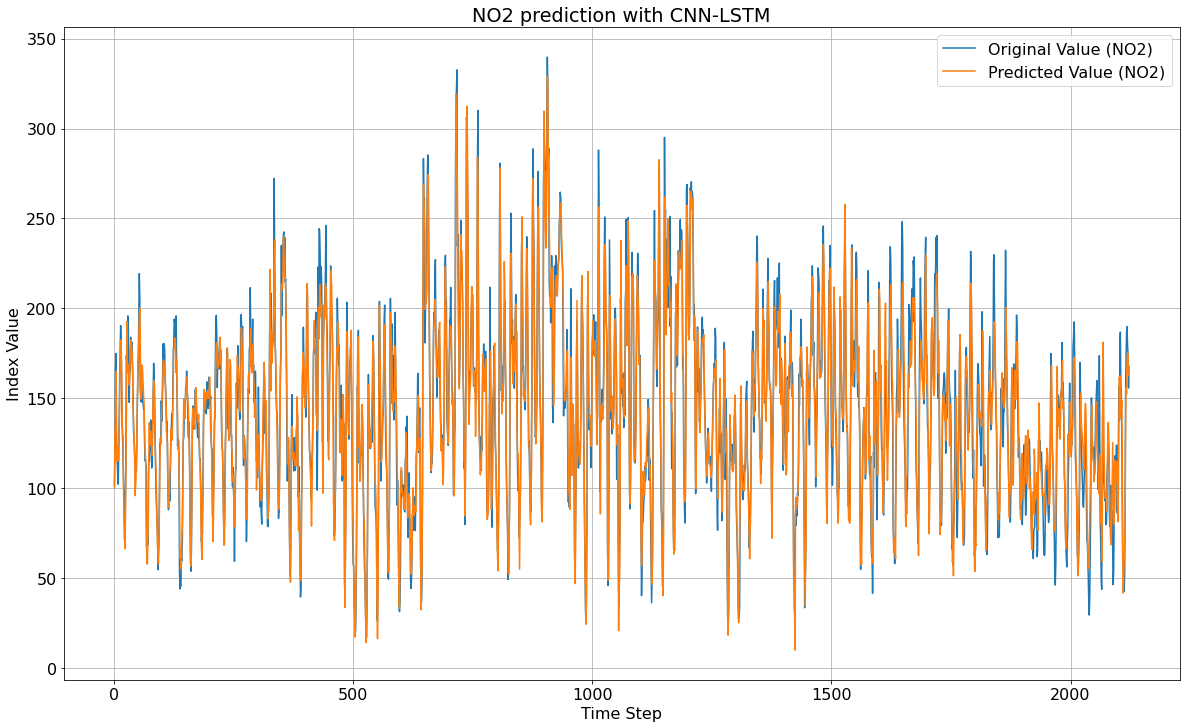

In [81]:
plt.figure(figsize=(20, 12))
plot_series(np.arange( 1, len(series)-G.WINDOW_SIZE+1 ), series_y)
plot_series(np.arange( 1, len(series)-G.WINDOW_SIZE+1 ), series_y_hat_cnn_lstm)
plt.ylabel("Index Value")
plt.xlabel("Time Step")
plt.title("NO2 prediction with CNN-LSTM")
legend_drawn_flag = True
plt.legend(["Original Value (NO2)", "Predicted Value (NO2)"], loc=0, frameon=legend_drawn_flag)
plt.savefig("/content/gdrive/MyDrive/NO2/figures/cnn_lstm_forecasts_whole_NO2.svg")

In [82]:
# error series

abs_error_cnn_lstm = np.abs(series_y-series_y_hat_cnn_lstm)
series_test_hat_cnn_lstm = series_y_hat_cnn_lstm[-G.SPLIT_TIME:]
series_test_hat_cnn_lstm_up = []
series_test_hat_cnn_lstm_low = []

In [83]:
for i in range(len(series_test)):
  error = np.sort(abs_error_cnn_lstm[i:i-len(series_test)], kind='quicksort')[::-1]
  up_bound = np.quantile(error, [1-alpha])
  low_bound = -np.quantile(error, [1-alpha])
  series_test_hat_cnn_lstm_up.append(series_test_hat_cnn_lstm[i] + up_bound)
  series_test_hat_cnn_lstm_low.append(series_test_hat_cnn_lstm[i] + low_bound)

In [84]:
series_test_hat_cnn_lstm_up = np.array(series_test_hat_cnn_lstm_up)
series_test_hat_cnn_lstm_low = np.array(series_test_hat_cnn_lstm_low)

In [85]:
series_test_hat_cnn_lstm_up = np.squeeze(series_test_hat_cnn_lstm_up)
series_test_hat_cnn_lstm_low = np.squeeze(series_test_hat_cnn_lstm_low)

In [86]:
bound_width_cnn_lstm = series_test_hat_cnn_lstm_up-series_test_hat_cnn_lstm_low

In [87]:
PICP_cnn_lstm = PICP(series_test_hat_cnn_lstm_up, series_test_hat_cnn_lstm_low, series_test)

In [88]:
PICP_cnn_lstm

0.9060773480662984

In [89]:
NMPIW_cnn_lstm = NMPIW(series_test_hat_cnn_lstm_up, series_test_hat_cnn_lstm_low, series_test)

In [90]:
NMPIW_cnn_lstm

<tf.Tensor: shape=(), dtype=float64, numpy=0.3224184926872345>

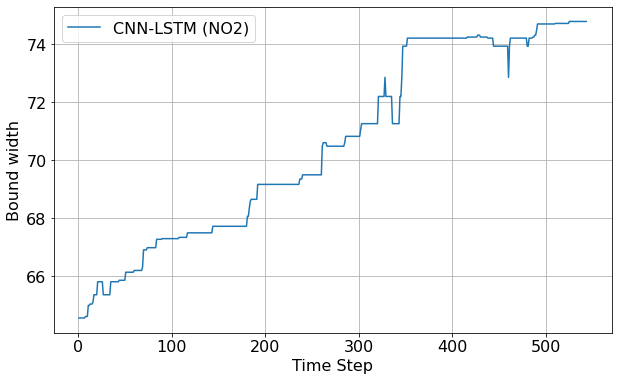

In [91]:
plt.figure(figsize=(10, 6))
plot_series(np.arange( 1, len(time_test)+1 ), bound_width_cnn_lstm)
plt.ylabel("Bound width")
plt.xlabel("Time Step")
legend_drawn_flag = True
plt.legend(["CNN-LSTM (NO2)"], loc=0, frameon=legend_drawn_flag)
plt.savefig("/content/gdrive/MyDrive/NO2/figures/cnn_lstm_forecasts_bound_width_NO2.svg")

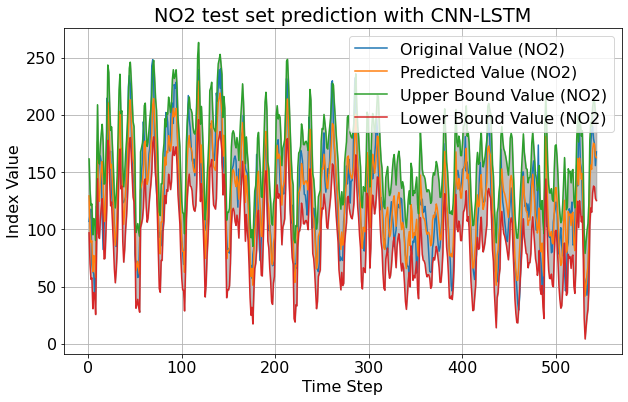

In [92]:
# Plot the forecast

plt.figure(figsize=(10, 6))
plot_series(np.arange( 1, len(time_test)+1 ), series_test)
plot_series(np.arange( 1, len(time_test)+1 ), series_test_hat_cnn_lstm)
plot_series(np.arange( 1, len(time_test)+1 ), series_test_hat_cnn_lstm_up)
plot_series(np.arange( 1, len(time_test)+1 ), series_test_hat_cnn_lstm_low)
plt.fill_between(np.arange( 1, len(time_test)+1 ), series_test_hat_cnn_lstm_up, series_test_hat_cnn_lstm_low, color='gray', alpha=0.5)
plt.ylabel("Index Value")
plt.xlabel("Time Step")
plt.title("NO2 test set prediction with CNN-LSTM")
legend_drawn_flag = True
plt.legend(["Original Value (NO2)", "Predicted Value (NO2)", "Upper Bound Value (NO2)", "Lower Bound Value (NO2)"], loc=0, frameon=legend_drawn_flag)
plt.savefig("/content/gdrive/MyDrive/NO2/figures/cnn_lstm_forecasts_bounds_NO2.svg")

In [93]:
rmse_cnn_lstm, mae_cnn_lstm, mape_cnn_lstm= compute_metrics(series_test, series_test_hat_cnn_lstm)

print(f"rmse: {rmse_cnn_lstm:.2f}, mae: {mae_cnn_lstm:.2f} , mape: {mape_cnn_lstm:.2f} for forecast")

rmse: 20.77, mae: 16.19 , mape: 14.88 for forecast


In [94]:
# Save model

cnn_lstm_ensemble[0].save("/content/gdrive/MyDrive/NO2/cnn_lstm_ensemble/cnn_lstm_NO2_0.h5")
cnn_lstm_ensemble[1].save("/content/gdrive/MyDrive/NO2/cnn_lstm_ensemble/cnn_lstm_NO2_1.h5")
cnn_lstm_ensemble[2].save("/content/gdrive/MyDrive/NO2/cnn_lstm_ensemble/cnn_lstm_NO2_2.h5")
cnn_lstm_ensemble[3].save("/content/gdrive/MyDrive/NO2/cnn_lstm_ensemble/cnn_lstm_NO2_3.h5")
cnn_lstm_ensemble[4].save("/content/gdrive/MyDrive/NO2/cnn_lstm_ensemble/cnn_lstm_NO2_4.h5")
cnn_lstm_ensemble[5].save("/content/gdrive/MyDrive/NO2/cnn_lstm_ensemble/cnn_lstm_NO2_5.h5")
cnn_lstm_ensemble[6].save("/content/gdrive/MyDrive/NO2/cnn_lstm_ensemble/cnn_lstm_NO2_6.h5")
cnn_lstm_ensemble[7].save("/content/gdrive/MyDrive/NO2/cnn_lstm_ensemble/cnn_lstm_NO2_7.h5")
cnn_lstm_ensemble[8].save("/content/gdrive/MyDrive/NO2/cnn_lstm_ensemble/cnn_lstm_NO2_8.h5")
cnn_lstm_ensemble[9].save("/content/gdrive/MyDrive/NO2/cnn_lstm_ensemble/cnn_lstm_NO2_9.h5")
cnn_lstm_ensemble[10].save("/content/gdrive/MyDrive/NO2/cnn_lstm_ensemble/cnn_lstm_NO2_10.h5")
cnn_lstm_ensemble[11].save("/content/gdrive/MyDrive/NO2/cnn_lstm_ensemble/cnn_lstm_NO2_11.h5")
cnn_lstm_ensemble[12].save("/content/gdrive/MyDrive/NO2/cnn_lstm_ensemble/cnn_lstm_NO2_12.h5")
cnn_lstm_ensemble[13].save("/content/gdrive/MyDrive/NO2/cnn_lstm_ensemble/cnn_lstm_NO2_13.h5")
cnn_lstm_ensemble[14].save("/content/gdrive/MyDrive/NO2/cnn_lstm_ensemble/cnn_lstm_NO2_14.h5")
cnn_lstm_ensemble[15].save("/content/gdrive/MyDrive/NO2/cnn_lstm_ensemble/cnn_lstm_NO2_15.h5")
cnn_lstm_ensemble[16].save("/content/gdrive/MyDrive/NO2/cnn_lstm_ensemble/cnn_lstm_NO2_16.h5")
cnn_lstm_ensemble[17].save("/content/gdrive/MyDrive/NO2/cnn_lstm_ensemble/cnn_lstm_NO2_17.h5")
cnn_lstm_ensemble[18].save("/content/gdrive/MyDrive/NO2/cnn_lstm_ensemble/cnn_lstm_NO2_18.h5")
cnn_lstm_ensemble[19].save("/content/gdrive/MyDrive/NO2/cnn_lstm_ensemble/cnn_lstm_NO2_19.h5")

IndexError: ignored

# Plot together

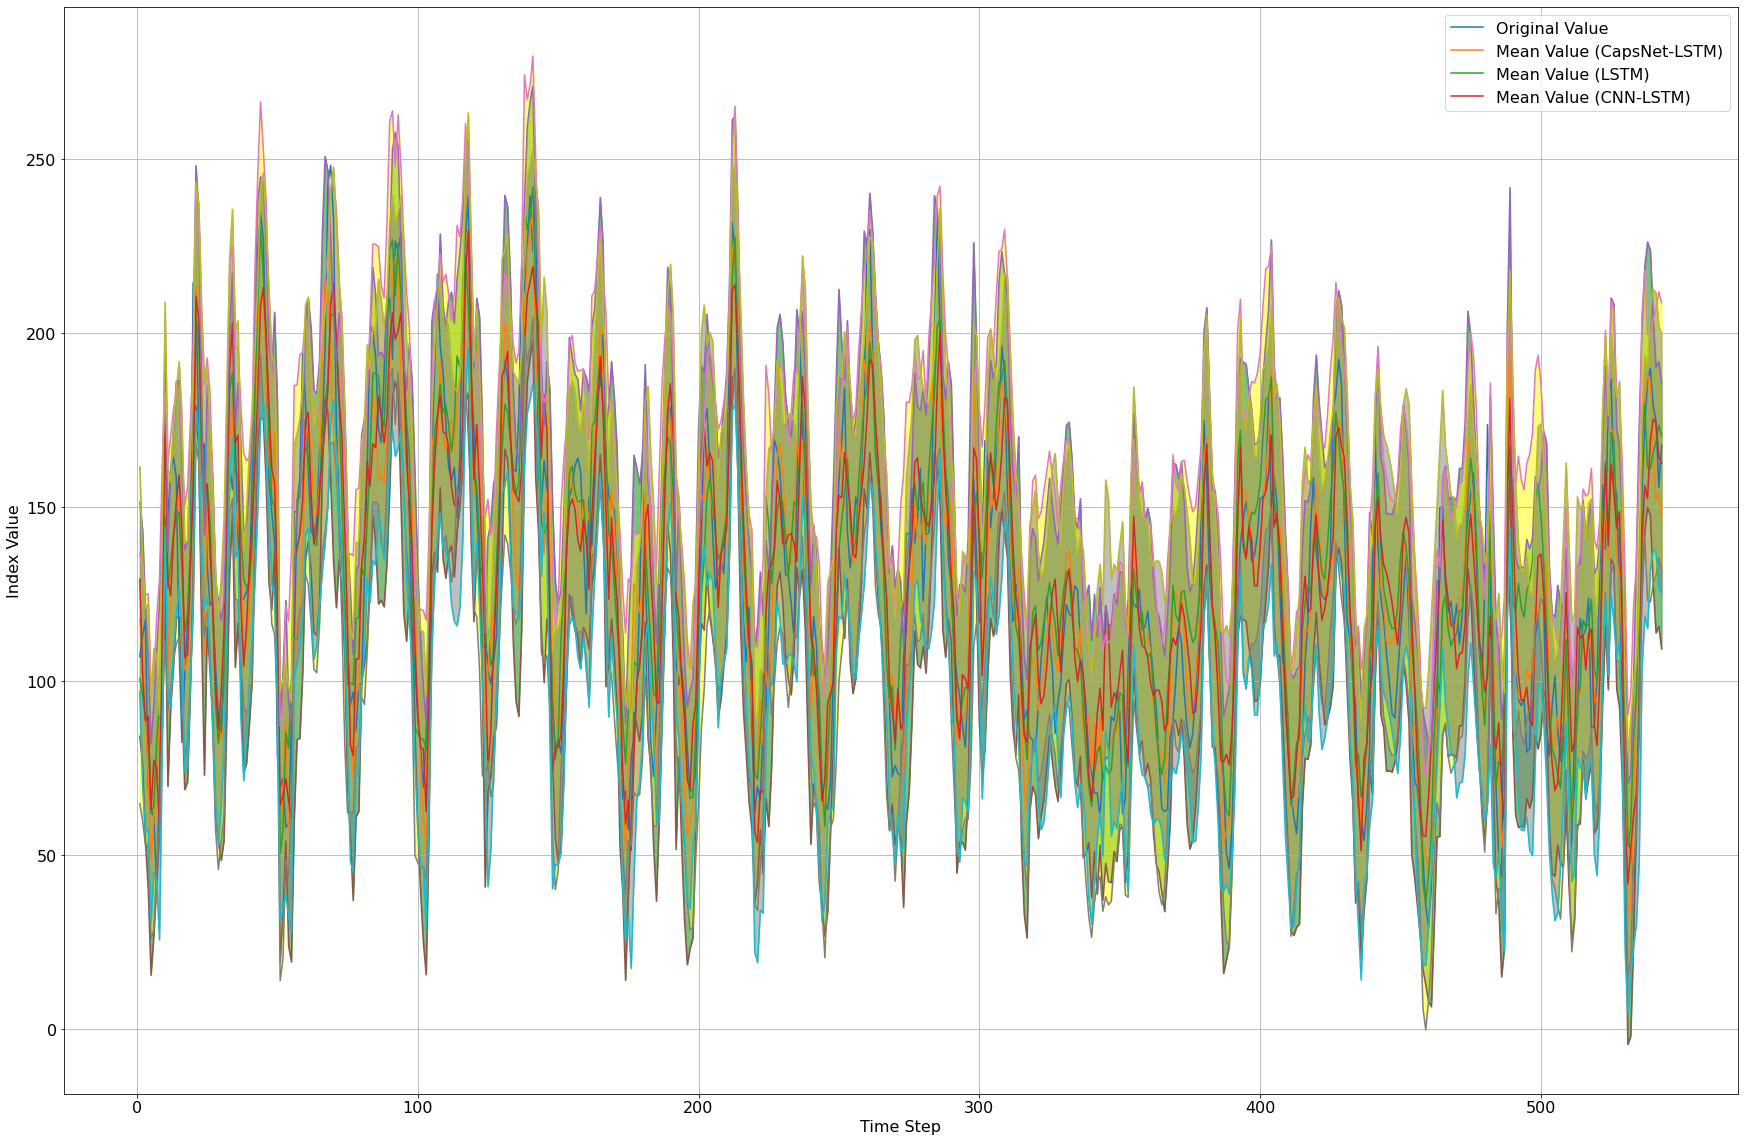

In [95]:
plt.figure(figsize=(30, 20))
plt.rcParams['font.size'] = '16'
plot_series(np.arange( 1, len(time_test)+1 ), series_test)
plot_series(np.arange( 1, len(time_test)+1 ), series_test_hat_capsnet_lstm)
plot_series(np.arange( 1, len(time_test)+1 ), series_test_hat_lstm)
plot_series(np.arange( 1, len(time_test)+1 ), series_test_hat_cnn_lstm)

plot_series(np.arange( 1, len(time_test)+1 ), series_test_hat_capsnet_lstm_up)
plot_series(np.arange( 1, len(time_test)+1 ), series_test_hat_capsnet_lstm_low)
plt.fill_between(np.arange( 1, len(time_test)+1 ), series_test_hat_capsnet_lstm_up, series_test_hat_capsnet_lstm_low, color='green', alpha=0.5)

plot_series(np.arange( 1, len(time_test)+1 ), series_test_hat_lstm_up)
plot_series(np.arange( 1, len(time_test)+1 ), series_test_hat_lstm_low)
plt.fill_between(np.arange( 1, len(time_test)+1 ), series_test_hat_lstm_up, series_test_hat_lstm_low, color='yellow', alpha=0.5)

plot_series(np.arange( 1, len(time_test)+1 ), series_test_hat_cnn_lstm_up)
plot_series(np.arange( 1, len(time_test)+1 ), series_test_hat_cnn_lstm_low)
plt.fill_between(np.arange( 1, len(time_test)+1 ), series_test_hat_cnn_lstm_up, series_test_hat_cnn_lstm_low, color='gray', alpha=0.5)


plt.ylabel("Index Value")
plt.xlabel("Time Step")
legend_drawn_flag = True
plt.legend(["Original Value", "Mean Value (CapsNet-LSTM)","Mean Value (LSTM)","Mean Value (CNN-LSTM)"], loc=0, frameon=legend_drawn_flag)
plt.savefig("/content/gdrive/MyDrive/NO2/all_together_forecasts_NO2.svg")

In [96]:
print(rmse_capsnet_lstm)
print(rmse_lstm)
print(rmse_cnn_lstm)

20.044487
19.576004
20.77019


In [97]:
print(mae_capsnet_lstm)
print(mae_lstm)
print(mae_cnn_lstm)

15.376527
15.582407
16.18783


In [98]:
print(mape_capsnet_lstm)
print(mape_lstm)
print(mape_cnn_lstm)

13.515176
14.4188385
14.883336


In [99]:
print(PICP_capsnet_lstm)
print(PICP_lstm)
print(PICP_cnn_lstm)

0.9263351749539595
0.9410681399631676
0.9060773480662984


In [100]:
print(NMPIW_capsnet_lstm)
print(NMPIW_lstm)
print(NMPIW_cnn_lstm)

tf.Tensor(0.3344537369705751, shape=(), dtype=float64)
tf.Tensor(0.34080508087942246, shape=(), dtype=float64)
tf.Tensor(0.3224184926872345, shape=(), dtype=float64)


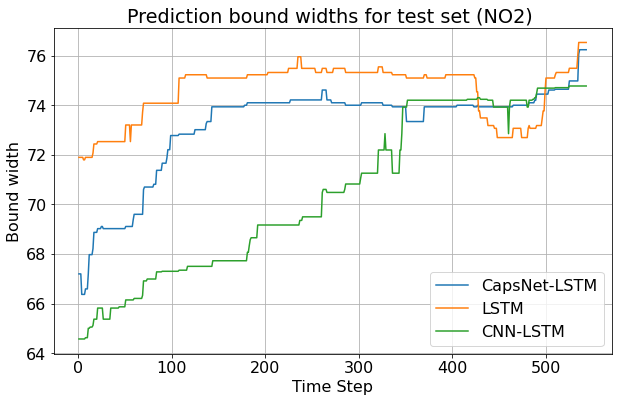

In [101]:
plt.figure(figsize=(10, 6))
plot_series(np.arange( 1, len(time_test)+1 ), bound_width_capsnet_lstm)
plot_series(np.arange( 1, len(time_test)+1 ), bound_width_lstm)
plot_series(np.arange( 1, len(time_test)+1 ), bound_width_cnn_lstm)
plt.ylabel("Bound width")
plt.xlabel("Time Step")
plt.title("Prediction bound widths for test set (NO2) ")
legend_drawn_flag = True
plt.legend(["CapsNet-LSTM","LSTM","CNN-LSTM"], loc=0, frameon=legend_drawn_flag)
plt.savefig("/content/gdrive/MyDrive/NO2/figures/lstm_forecasts_all_bound_widths_NO2.svg")